In [1]:
# -*- coding: utf-8 -*-
"""
Project: S-QuAPI for CPU
Date Created : 9/8/20
Date Last mod: 9/8/20
Author: Yoshihiro Sato
Description: Exciton dynamics of the FMO complex using S-QuAPI. 
             This script can be used to reproduce Fig.3 of Y.Sato, 
             Journal of Chemical Physics 150, 224108 (2019).
Notes:
    - Select the executable from squapi, squapi_omp, and squapi_mpi.
      The default is prog=squpai_omp
    - To reproduce Fig.3 of Y.Sato(2019), set Dkmax=4 and theta=1e-9, 
      but it will take a long time for a platform with a small number 
      of CPU cores.
"""

#==============================================================================
#                           Definitions
#==============================================================================
import numpy as np
import subprocess
import sys

bin_dir = '../bin/'
sys.path.append(bin_dir)
import squapi as sq 

# Constant (defined in squapi.py):
fs = sq.fs      # 1 fs in units of [ps]

def shell(cmd):
    '''
    Executes 'cmd' on shell and monitors the shell output real-time.
    '''
    process = subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True)
    while True:
        output = process.stdout.readline().decode()
        if output == '' and process.poll() is not None:
            break
        if output:
            print(output.strip())
            
#==============================================================================
#                               Model
#==============================================================================
# System Hamiltonian (see Y.Sato (2019) Eq.(22))
H0 = [[  240, -87.7,   5.5,  -5.9,   6.7, -13.7,  -9.9],
      [-87.7,   315,  30.8,   8.2,   0.7,  11.8,   4.3],
      [  5.5,  30.8,     0, -53.5,  -2.2,  -9.6,   6.0],
      [ -5.9,   8.2, -53.5,   130, -70.7, -17.0, -63.3],
      [  6.7,   0.7,  -2.2, -70.7,   285,  81.1,  -1.3],
      [-13.7,  11.8,  -9.6, -17.0,  81.1,   435,  39.7],
      [ -9.9,   4.3,   6.0, -63.3,  -1.3,  39.7,   245],
     ]

# Bath:
T   = 77                      # Bath temperature in [K]
s   = np.identity(len(H0))    # System-bath coupling array 
lam = [35] * len(s)           # Reorganization energies in [cm^-1]
mu  = lam                     # Counter terms in [cm^-1]

# Bath function with the approximated B777 spectral density:
g   = lambda bath, t: sq.g777(t, lam[bath], T)

# Initial density matirx:
rhosA = np.zeros_like(H0)
rhosA[0,0] = 1                # BChl 1 excited
rhosB = np.zeros_like(H0)
rhosB[5,5] = 1                # BChl 6 excited

#==============================================================================
#                              Parameters 
#==============================================================================
Dkmax = 3        # The maximum number of memory steps
Dt    = 25 * fs  # Time slice of path integral
Nmax  = 40       # The maximu times step
theta = 5e-7     # Threshold for propagator filtering

# Select from squapi, squapi_omp, squapi_mpi:
prog  = 'squapi_omp'
# Select the initial density matrix:
rhos0 = rhosA.copy()

#==============================================================================
#                             Computation 
#==============================================================================
# Generate system.dat:
sq.save_system(H0, s, lam, mu, T, Dt, Dkmax, g, scaled=True)
# Generate init.dat:
sq.save_init(rhos0)
# Run the squapi executable: 
cmd = bin_dir + prog + ' system.dat init.dat ' + str(Nmax) + ' ' + str(theta)
if prog == 'squapi_mpi':
    cmd = 'mpiexec ' + cmd 
shell(cmd)

----- Date and Time --------------------
Tue Sep  8 10:32:16 EDT 2020
----- parameters -----------------------
Dt     = 0.025 ps
Nmax   = 40
Dkmax  = 3
M      = 7
theta  = 5e-07
----- generate Cn and Wn ---------------
size of C1 = 49
size of C2 = 2401  lap time = 0.001326 sec
size of C3 = 114251  lap time = 0.045187 sec
----- generate Cnmap -------------------
lap time = 0.019933 sec
----- generate rhos --------------------
N = 0 of 40 lap time = 0.000811 sec tr = 1
N = 1 of 40 lap time = 0.002961 sec tr = 1
N = 2 of 40 lap time = 0.023354 sec tr = 1
N = 3 of 40 lap time = 0.760438 sec tr = 1
N = 4 of 40 lap time = 3.3169 sec tr = 1
N = 5 of 40 lap time = 4.80235 sec tr = 1
N = 6 of 40 lap time = 4.5119 sec tr = 1
N = 7 of 40 lap time = 4.60964 sec tr = 1
N = 8 of 40 lap time = 5.15225 sec tr = 1
N = 9 of 40 lap time = 4.53802 sec tr = 1
N = 10 of 40 lap time = 4.63883 sec tr = 0.999999
N = 11 of 40 lap time = 4.65707 sec tr = 0.999999
N = 12 of 40 lap time = 4.5121 sec tr = 0.999999


<Figure size 550x350 with 1 Axes>

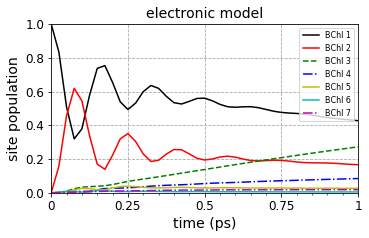

In [2]:
#==============================================================================
#                              Graphics 
#==============================================================================
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, LogLocator)
# extract rhos from rhos.dat:
rhos = sq.load_rhos('rhos.dat')
opts = '-k', '-r', '--g', '-.b', '-y', '-c', '-.m', '-b', '--b', '--k'
colors = 'k', 'r', 'g', 'b', 'y', 'c', 'm'

times = np.array([k * Dt for k in range(Nmax + 1)])
fig, ax = plt.subplots(figsize=(5.5, 3.5))
ax.set_title('electronic model', fontsize=14)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax.set_xlabel('time (ps)', fontsize=14)
ax.set_ylabel('site population', fontsize=14)
ax.grid(color='0.65', linestyle='--')
for m in range(len(rhos[0])):
    ax.plot(times, rhos[:, m, m].real, opts[m], label='BChl ' + str(m+1), fillstyle='none')
#    if m < 5:
#        ax.plot(times, rhos[:, m, m].real, colors[m] + 'o', fillstyle='none') 
ax.legend(loc='upper right', shadow=False, fontsize=8)
ax.set_xlim(0, times.max())
ax.set_ylim(0, 1)
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_xticklabels([0, 0.25, 0.5, 0.75, 1])
ax.set_aspect(0.55)
plt.show()